# Beam Size Tests

**Scott Prahl**

**March 2020, Version 3**

These are all artificial tests.  A perfect astigmatic Gaussian beam is generated and then noise (and/or and offset) is added to the entire image.  Examples are shown in which the default algorithm works perfectly and also fails spectacularly.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

## The problem of background

### Recall the definition for beam center

As mentioned in the literature, image artifacts outside the beam can cause dramatic errors when the ISO 11146 algorithm is used.  Consider just finding the 
center in the horizontal direction.  We calculate the total power $P$ over the entire image of the beam

$$
P = \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} E_{ij}
$$

and then locate the center of this beam with the following sum (that approximates the weighted integral)

$$
x_c \approx {1\over P} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i \cdot E_{ij}
$$

Now if the image is zero outside the beam, the $E_{ij}=0$ for those pixels and these contribute *nothing* in either of the sums above.  

### Constant backgroud

In the case constant background with a value equal $\varepsilon P$, 

$$
E_{ij}=E'_{ij} + \varepsilon P
$$ 

The calculation of $x_c$ becomes
$$
x_c \approx \frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} +  \frac{\varepsilon N(N-1)M P}{2P'} \approx
\frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} + \varepsilon\frac{N^2M}{2} 
$$

Because the last term is always positive, the predicted center of the beam will 

* always be displaced to the right!
* have a greater error for greater image sizes
* be very sensitive to extra horizonal width

So, extra *background* across the image is problematic for locating the beam center.  Ideally, background image noise  would just be replaced with zeros.  

### Dealing with background

The `lbs.beam_size()` algorithm should work robustly for a variety of images.  What are the options?

#### Subtracting minimum

One simple solution is to just subtract the minimum value in image from the image before processing.  Unfortunately, in real images, the minimum value tends to be close to zero and very little background is removed.

#### Thresholding

A slightly less trivial solution uses the maximum value in the image $E_{max}$ and an arbitrary threshold fraction $f_{th}$.  One simply replaces all values in the image that are less than $E_{max} f_{th}$ with zero.  Currently the `lbs.beam_size()` algorithm defaults to $f_{th}$=0.1.

#### Actual algorithm Used

With a little thought, one soon realizes that thresholding will always result in beam diameters that are too small --- because the shoulders of the beam have been removed.  So we arrive at the method used by `lbs.beam_size()`

1. Zero all pixels below a certain threshold.  Use the thresholded image to estimate the center and beam size.

2. Use these estimated values to create a mask around the beam (twice the diameter) and then reprocess the image. 

Thus one can use a relatively large threshold in the first step that otherwise would significantly truncate the shoulders of the beam.  The second step then includes the shoulders and a better beam diameter can be obtained.  Because all pixels that are far from the beam are zeroed by the mask, background effects are minimized.

## Test 1. Simple, noise-free rotated elliptical beam

In this and all rest of the test functions, the maximum value in the test array is 256.

No gaussian noise, works fine!

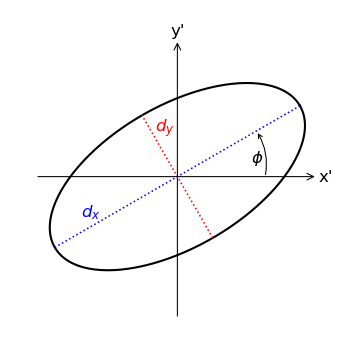

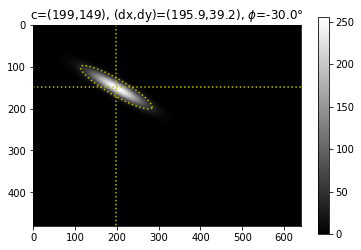

In [2]:
lbs.draw_beam_figure()

xc=200
yc=150
dx=200
dy=40
phi=-30*np.pi/180
h=640
v=480

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)

## Test 2. Tiny bit (2%) gaussian noise

It still works!

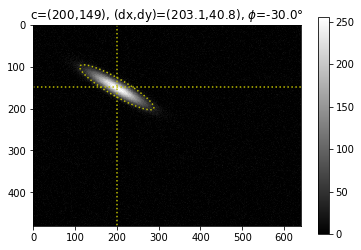

In [3]:
xc=200
yc=150
dx=200
dy=40
phi=-30*np.pi/180
h=640
v=480

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=5)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)

## Test 3. Test 3 5% Gaussian Noise

The default settings do not work.  Need to increase the default threshold from 10% (0.10) to 20% (0.20)

yikes! pretty terrible with the default 10% threshold


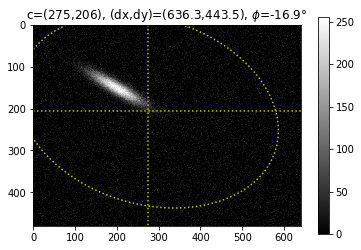

looks much better when the threshold is increased


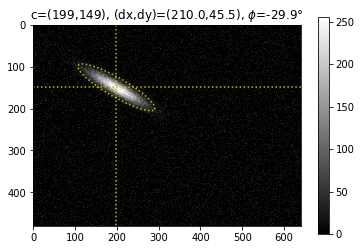

In [4]:
xc=200
yc=150
dx=200
dy=40
phi=-30*np.pi/180
h=640
v=480

print('yikes! pretty terrible with the default 10% threshold')
test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=13)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.show()

print('looks much better when the threshold is increased')
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test, threshold=0.2)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)

## Test 4. Add 5% constant offset to the entire image

This works fine.

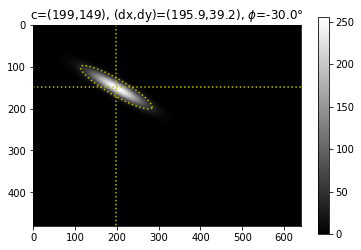

In [5]:
xc=200
yc=150
dx=200
dy=40
phi=-30*np.pi/180
h=640
v=480

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,offset=13)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.show()

## Test 5. 5% gaussian noise and a 5% offset

This fails.  It doesn't work with threshold=0.2, instead need to increase the threshold to 0.3.

Changing the threshold is easy, as shown below.

not good


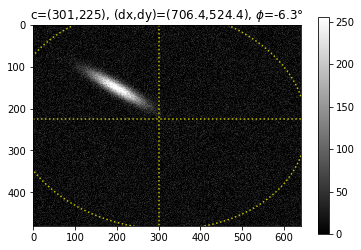

Increase default threshold, and the fit is now good


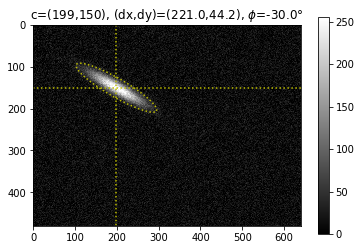

In [6]:
xc=200
yc=150
dx=200
dy=40
phi=-30*np.pi/180
h=640
v=480

print('not good')
test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,offset=13,noise=13)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.show()

print('Increase default threshold, and the fit is now good')

xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test, threshold=0.3)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.show()

## Test 6.  Equal sizes

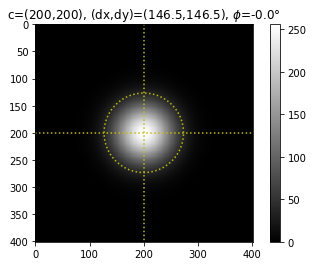

In [7]:
xc=200
yc=200
dx=150
dy=150
phi=0*np.pi/180
h=401
v=401

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.show()



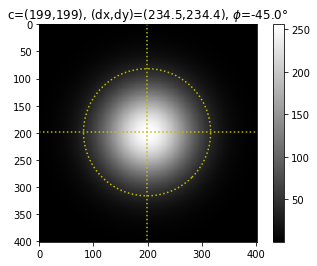

In [8]:
xc=200
yc=200
dx=240
dy=240
phi=-45*np.pi/180
h=401
v=401

test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi)
xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)
lbs.plot_image_and_ellipse(test,xc_found, yc_found, dx_found, dy_found, phi_found)
plt.show()